In [17]:
#!/bin/python3
from datetime import datetime, timezone, timedelta
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time
import pytz
%matplotlib widget
# %matplotlib inline

def get_data(start, end):
    api_url = "https://api.awattar.de/v1/marketdata"
    df = pd.DataFrame()

    start_timestamp = start
    end_timestamp = end

    params = {
        'start': start_timestamp,
        'end': end_timestamp
    }

    start_time = time.time()
    response = requests.get(api_url, params=params)
    end_time = time.time()

    print(f"took {end_time - start_time:.6f} seconds to execute.")

    if response.status_code == 200:
        data = response.json()

        with open(f'../data/api_response_{start}_{end}.json', 'w') as json_file:
            json.dump(data, json_file, indent=4)

        return pd.DataFrame(data["data"])
    else:
        print(f"Fehler bei der Anfrage. Statuscode: {response.status_code}")
        return df

In [47]:
def convert_to_germany_time(epoch):
    germany_timezone = pytz.timezone("Europe/Berlin")
    dt_utc = datetime.fromtimestamp(epoch / 1000, tz=timezone.utc)
    dt_germany = dt_utc.replace(tzinfo=pytz.utc).astimezone(germany_timezone)
    return dt_germany.strftime('%d-%m-%Y %H:%M:%S %Z')

def read_db(conn, start=datetime(1970, 1, 1, 1), end=datetime(1970, 1, 1, 1)):
    start = int(start.timestamp() * 1000)
    end = int(end.timestamp() * 1000)
    print(f"start: {start}, end: {end}")
    df_db = pd.DataFrame()
    start_time = time.time()
    df_db = pd.read_sql('select * from awattar', conn)
    print(f"db read took {(time.time()) - start_time:.6f} seconds to execute.")
    if start == 0 and end == 0:
        return df_db
    elif start <= end:
        return (df_db[(df_db['start_timestamp'] >= start) & (df_db['start_timestamp'] < end)])

In [26]:
%%script false --no-raise-error # skip this cell
df = get_data(int(datetime(2019, 1, 1).timestamp() * 1000), int(datetime(2020, 1, 1).timestamp() * 1000))
assert not df.empty

df["marketprice"] = (df["marketprice"] * 0.1).round(2)
df["unit"] = "Cent/kWh"
df["date"] = df["start_timestamp"].apply(lambda epoch: convert_to_germany_time(epoch))
# df.drop(0, axis=0, inplace=True)
# df.reset_index(drop=True, inplace=True)
# df = df.head(100)
df

## Database handling

In [48]:
write_to_db = False

import sqlite3
if write_to_db:
    df = get_data(int(datetime(2010, 1, 1).timestamp() * 1000), int(datetime(2023, 1, 1).timestamp() * 1000))
assert not df.empty

df["marketprice"] = (df["marketprice"] * 0.1).round(2)
df["unit"] = "Cent/kWh"
df["date"] = df["start_timestamp"].apply(lambda epoch: convert_to_germany_time(epoch))

conn = sqlite3.connect('../data/db.sqlite')
if write_to_db:
    df.to_sql('awattar', conn, if_exists='replace', index=False)

df_db = read_db(conn, datetime(2019, 1, 1), datetime(2020, 1, 1))
print("data from sqlite db:")
df_db

start: 1546297200000, end: 1577833200000
db read took 0.465178 seconds to execute.
data from sqlite db:


,start_timestamp,end_timestamp,marketprice,unit,date
44064,1546297200000,1546300800000,2.83,Cent/kWh,01-01-2019 00:00:00 CET
44065,1546300800000,1546304400000,1.01,Cent/kWh,01-01-2019 01:00:00 CET
44066,1546304400000,1546308000000,-0.41,Cent/kWh,01-01-2019 02:00:00 CET
44067,1546308000000,1546311600000,-0.99,Cent/kWh,01-01-2019 03:00:00 CET
44068,1546311600000,1546315200000,-0.74,Cent/kWh,01-01-2019 04:00:00 CET
...,...,...,...,...,...
52819,1577815200000,1577818800000,4.60,Cent/kWh,31-12-2019 19:00:00 CET
52820,1577818800000,1577822400000,4.22,Cent/kWh,31-12-2019 20:00:00 CET
52821,1577822400000,1577826000000,3.97,Cent/kWh,31-12-2019 21:00:00 CET
52822,1577826000000,1577829600000,3.89,Cent/kWh,31-12-2019 22:00:00 CET


Marketprice mittel: 0.38


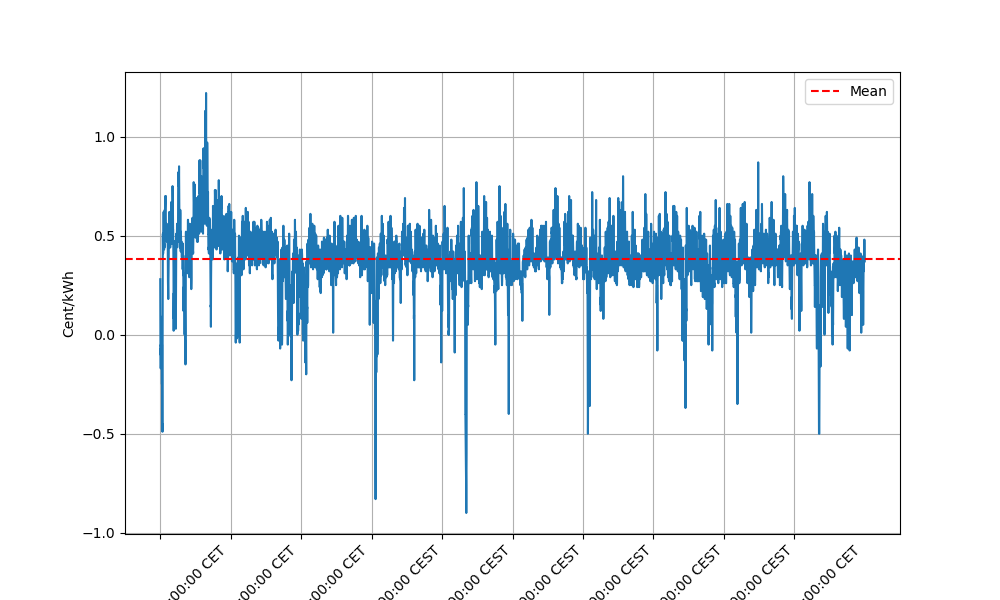

In [21]:
# print(df.dtypes)
market_mean = round(df["marketprice"].mean(), 2)
print(f"Marketprice mittel: {market_mean}")
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["marketprice"])
plt.ylabel(df["unit"].iloc[0])
plt.axhline(y=market_mean, color='r', linestyle='--', label='Mean')
plt.xticks(df["date"][::round(len(df["date"])/10)], rotation=45)
plt.legend()
plt.grid()
plt.show()

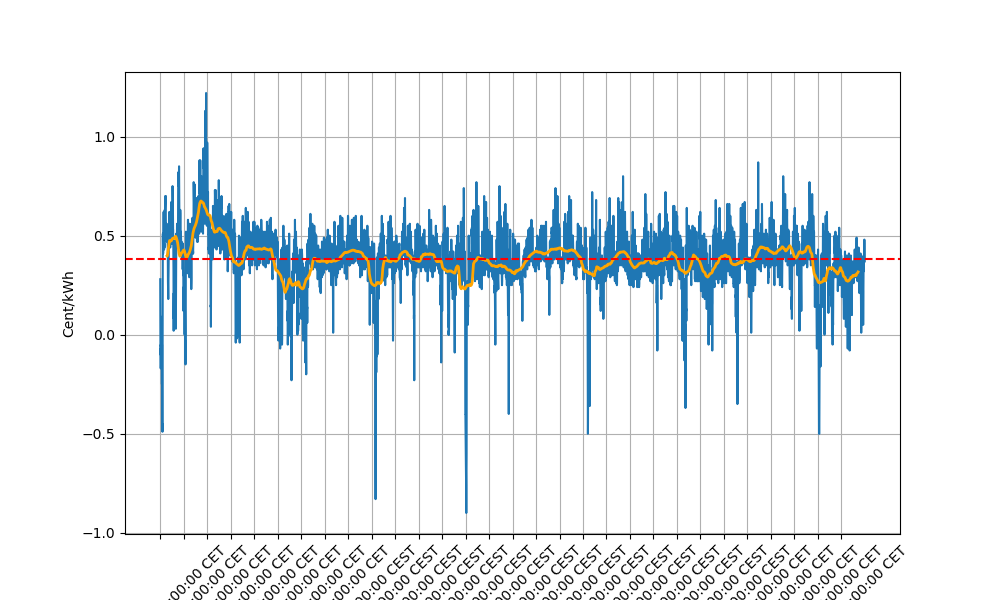

In [22]:
rolling_mean = df["marketprice"].rolling(window=24*7, center=True).mean()
# df = df.head(100)

plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["marketprice"], label='Original Data', linestyle='-')
plt.plot(df["date"], rolling_mean, label='Rolling Average', linestyle='-', linewidth=2, color='orange')

plt.ylabel(df["unit"].iloc[0])
plt.axhline(y=market_mean, color='r', linestyle='--', label='Mean')
plt.xticks(df["date"][::round(len(df["date"])/30)], rotation=45)
plt.grid()
plt.show()

In [23]:
df2 = pd.read_csv("data/Gro_handelspreise_202301010000_202312092359_Stunde.csv", delimiter=";")
df2 = df2[["Datum", "Anfang", "Ende", "Deutschland/Luxemburg [€/MWh] Originalauflösungen"]]
df2.rename(columns={"Deutschland/Luxemburg [€/MWh] Originalauflösungen": "marketprice"}, inplace=True)
df2["unit"] = "Cent/kWh"
df2['date'] = pd.to_datetime(df2['Datum'] + ' ' + df2['Anfang'].astype(str), format='%d.%m.%Y %H:%M')

# df.drop(0, axis=0, inplace=True)

df2

FileNotFoundError: [Errno 2] No such file or directory: 'data/Gro_handelspreise_202301010000_202312092359_Stunde.csv'

## Create energy consumption curve

In [ ]:
hours = list(range(24))
total_kwh_year = 4000
total_kwh_day = 11

def distribute_energy(total_kwh=11, hours=list(range(24))):
    morning_weight = 0.2
    midday_weight = 0.5
    evening_weight = 0.3
    
    energy_distribution = [0] * len(hours)
    
    for hour in hours:
        if 6 <= hour < 10:  # Morning spike
            energy_distribution[hour] = total_kwh * morning_weight / 4
        elif 10 <= hour < 13:  # Midday spike
            energy_distribution[hour] = total_kwh * midday_weight / 3
        elif 18 <= hour < 22:  # Evening spike
            energy_distribution[hour] = total_kwh * evening_weight / 4
        else:
            energy_distribution[hour] = total_kwh / 24  # Rest of the day
            
    return energy_distribution

# energy_distribution = distribute_energy(total_kwh_day)
# print(energy_distribution)
# print(f"Total energy: {sum(energy_distribution)}")

# plt.figure(figsize=(10, 6))
# plt.plot(range(24), energy_distribution, marker='o', linestyle='-', color='b')
# plt.title('Hourly Energy Distribution')
# plt.xlabel('Hour of the Day')
# plt.ylabel('kWh')
# plt.grid(True)
# plt.show()

[0.00813508 0.03217501 0.09910777 0.23776617 0.44436472 0.6475839
 0.73907529 0.67306159 0.5267511  0.43589405 0.46952543 0.57258454
 0.6278727  0.57768004 0.48600207 0.47551278 0.60077731 0.78076973
 0.86112463 0.75529207 0.51839139 0.27738979 0.11562535 0.03753748]
11.0 kWh/Day


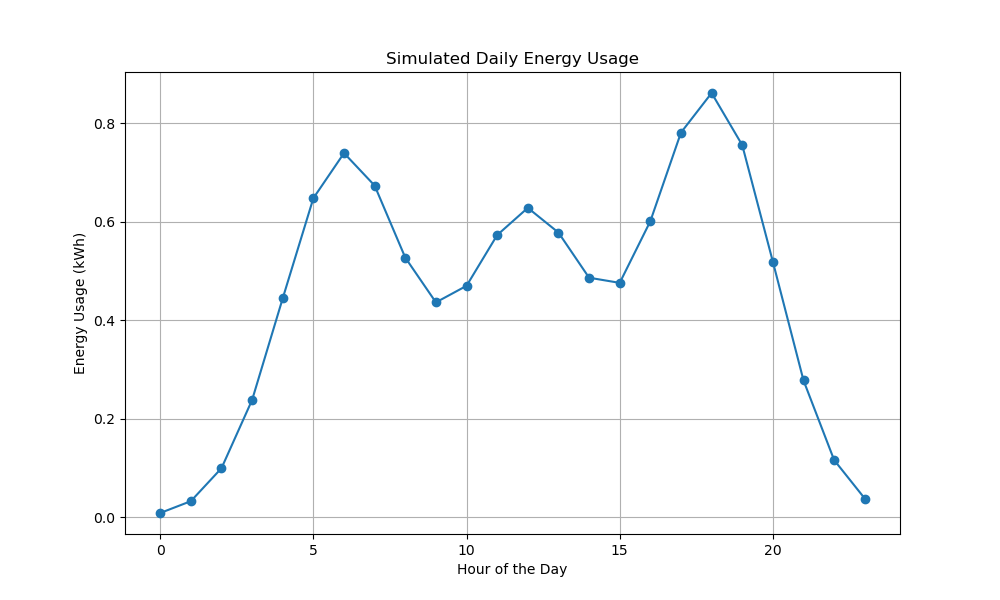

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_energy_usage(total_daily_energy=11, num_hours=24):
    # Create an array representing the hours of the day
    hours = np.arange(num_hours)

    # Define the function to model energy usage with spikes
    energy_usage = total_daily_energy * (
        0.6 * np.exp(-0.5 * ((hours - 6) / 2.0) ** 2) +
        0.5 * np.exp(-0.5 * ((hours - 12) / 2.0) ** 2) +
        0.7 * np.exp(-0.5 * ((hours - 18) / 2.0) ** 2)
    )

    # Ensure the energy usage is non-negative
    energy_usage = np.maximum(energy_usage, 0)

    # Normalize the energy usage to the total daily energy
    energy_usage = total_daily_energy * (energy_usage / np.sum(energy_usage))

    return energy_usage

energy_usage = simulate_energy_usage(11)
print(energy_usage)
print(f"{sum(energy_usage)} kWh/Day")

plt.figure(figsize=(10, 6))
plt.plot(hours, energy_usage, marker='o')
plt.title('Simulated Daily Energy Usage')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Usage (kWh)')
plt.grid(True)
plt.show()


In [ ]:
marketprice_data = df["marketprice"].to_numpy()
print(len(marketprice_data))
print(len(energy_usage))

kilowatthours = np.tile(energy_usage, len(df) // 24 + 1)[:len(df)]
df['kwh'] = kilowatthours
df['Price per hour'] = df['marketprice'] * df['kwh'] / 100

print(f"Preis für Jahr: {df['Price per hour'].sum()}")
df

8760
24
Preis für Jahr: 161.02047323626934


,start_timestamp,end_timestamp,marketprice,unit,date,kwh,Price per hour
0,1546297200000,1546300800000,2.83,Cent/kWh,01-01-2019 00:00:00 CET,0.008135,0.000230
1,1546300800000,1546304400000,1.01,Cent/kWh,01-01-2019 01:00:00 CET,0.032175,0.000325
2,1546304400000,1546308000000,-0.41,Cent/kWh,01-01-2019 02:00:00 CET,0.099108,-0.000406
3,1546308000000,1546311600000,-0.99,Cent/kWh,01-01-2019 03:00:00 CET,0.237766,-0.002354
4,1546311600000,1546315200000,-0.74,Cent/kWh,01-01-2019 04:00:00 CET,0.444365,-0.003288
...,...,...,...,...,...,...,...
8755,1577815200000,1577818800000,4.60,Cent/kWh,31-12-2019 19:00:00 CET,0.755292,0.034743
8756,1577818800000,1577822400000,4.22,Cent/kWh,31-12-2019 20:00:00 CET,0.518391,0.021876
8757,1577822400000,1577826000000,3.97,Cent/kWh,31-12-2019 21:00:00 CET,0.277390,0.011012
8758,1577826000000,1577829600000,3.89,Cent/kWh,31-12-2019 22:00:00 CET,0.115625,0.004498
